In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow import data, convert_to_tensor
from tensorflow.keras import  layers, Sequential, losses
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('../datasets/heart-disease/heart.csv')
display(df)



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'ca'}>,
        <AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'cp'}>],
       [<AxesSubplot:title={'center':'exang'}>,
        <AxesSubplot:title={'center':'fbs'}>,
        <AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'restecg'}>],
       [<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'thal'}>],
       [<AxesSubplot:title={'center':'thalach'}>,
        <AxesSubplot:title={'center':'trestbps'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

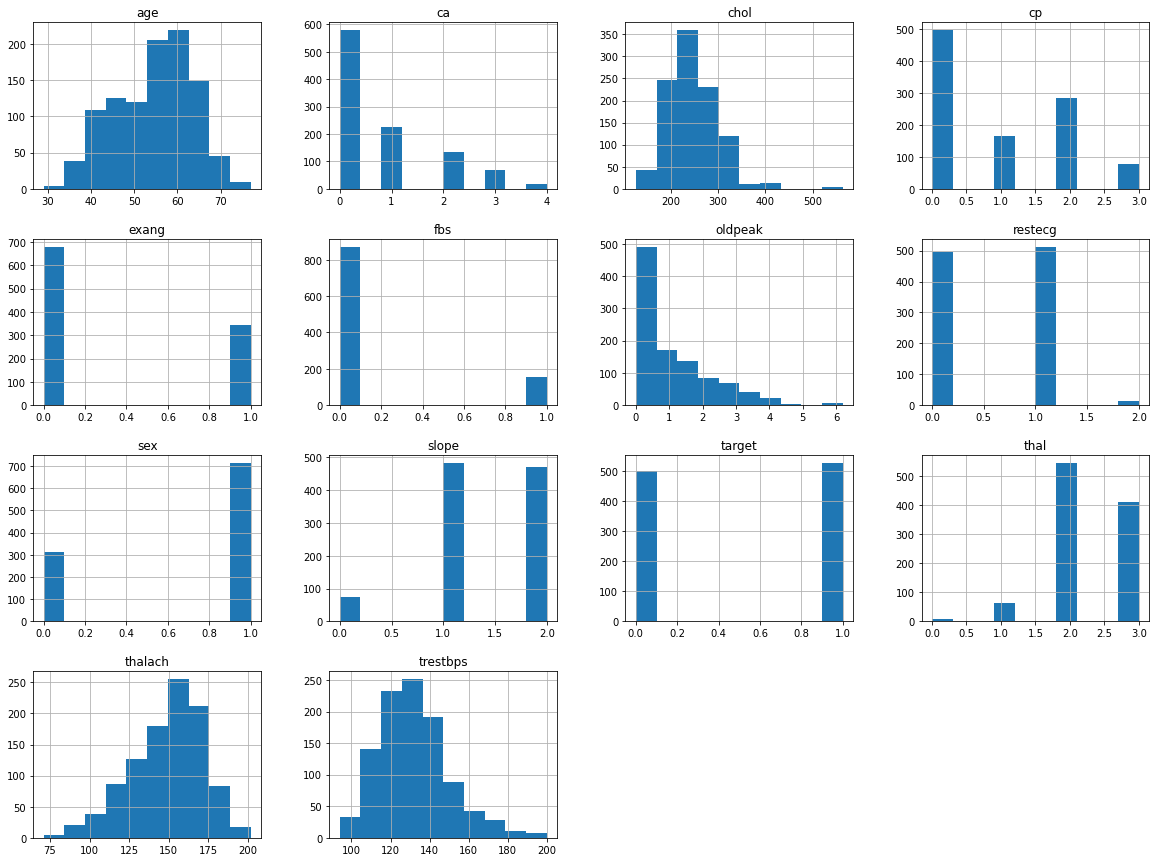

In [3]:
df.hist(figsize=(20,15))

In [4]:
train, test = train_test_split(df, test_size = 0.2)
train, val  = train_test_split(train, test_size = 0.2)
print(train.shape)
print(val.shape)
print(test.shape)

(656, 14)
(164, 14)
(205, 14)


In [6]:
#wraping dataframe with tf.data
def df_to_dataset(df, shuffle = True, batch_size = 32):
    dataframe = df.copy()
    labels = df.pop('target')
    ds = data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


In [7]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size = batch_size)
val_ds = df_to_dataset(val, batch_size = batch_size)
test_ds = df_to_dataset(test, batch_size = batch_size)

In [8]:
df.columns[:-1]

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [22]:
# Getting list of features
# Ignoring the 'target'
features = []

for f in list(df.columns[:-1]):
    features.append(feature_column.numeric_column(f))
features

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sex', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='cp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fbs', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='restecg', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='exang', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericCol

#### For structured data we need to use feature layer

In [10]:
feature_layer = layers.DenseFeatures(features)


In [11]:
#early_stopping
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [23]:
model = Sequential([
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

fit_log = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=[es_cb])

Train for 132 steps, validate for 33 steps
Epoch 1/200
132/132 [==============================] - 1s 9ms/step - loss: 1.9324 - accuracy: 0.6540 - val_loss: 1.1573 - val_accuracy: 0.6037
Epoch 2/200
132/132 [==============================] - 0s 2ms/step - loss: 1.1265 - accuracy: 0.6280 - val_loss: 0.6066 - val_accuracy: 0.6220
Epoch 3/200
132/132 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.6921 - val_loss: 0.6398 - val_accuracy: 0.6463
Epoch 4/200
132/132 [==============================] - 0s 2ms/step - loss: 0.5863 - accuracy: 0.7134 - val_loss: 0.6101 - val_accuracy: 0.5976
Epoch 5/200
132/132 [==============================] - 0s 2ms/step - loss: 0.5778 - accuracy: 0.7119 - val_loss: 0.7659 - val_accuracy: 0.5549
Epoch 6/200
132/132 [==============================] - 0s 3ms/step - loss: 0.5599 - accuracy: 0.7012 - val_loss: 0.6491 - val_accuracy: 0.5610
Epoch 7/200
132/132 [==============================] - 0s 2ms/step - loss: 0.4976 - accuracy: 0.751

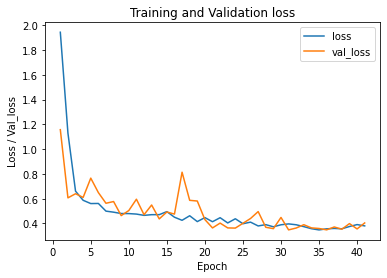

In [31]:
loss = fit_log.history['loss']
val_loss = fit_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="loss" )
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training and Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss / Val_loss')
plt.legend()
plt.show()

In [24]:
model.evaluate(test_ds)

41/41 [==============================] - 0s 1ms/step - loss: 0.4833 - accuracy: 0.6829


[0.48326368993375357, 0.68292683]

In [25]:
model.save('heart_disease_classifier')

INFO:tensorflow:Assets written to: heart_disease_classifier\assets


##### Showing probability

In [26]:
 from tensorflow import nn

 pred = model.predict(test_ds)
 prob = nn.sigmoid(pred[0])

In [27]:
print(
    "This person had a %.1f percent probability "
    "of getting heart decease." % (100 * prob)
)

This person had a 45.4 percent probability of getting heart decease.
